In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, fbeta_score, recall_score

%matplotlib inline

### The following code block creates a dataset of students who received grades for all 3 questions in the dataset

In [2]:
df = pd.read_excel('litmus_results_trial1.xlsx')
q1_score = df[pd.notnull(df.question_id_11459_score)]
q1q2 = q1_score[pd.notnull(q1_score.question_id_11460_score)]
q1q2q3 = q1q2[pd.notnull(q1q2.question_id_11461_score)]

In [3]:
"Remove any null values"
q1_answers = q1q2q3.question_id_11459_answer
q1_answers = q1_answers.apply(lambda x: x if pd.notnull(x) else "")

q2_answers = q1q2q3.question_id_11460_answer
q2_answers = q2_answers.apply(lambda x: x if pd.notnull(x) else "")

q3_answers = q1q2q3.question_id_11461_answer
q3_answers = q3_answers.apply(lambda x: x if pd.notnull(x) else "")

In [4]:
"Turn the student answers into a list"
q1_answers = q1_answers.tolist()
q2_answers = q2_answers.tolist()
q3_answers = q3_answers.tolist()

In [5]:
"Grab the solutions from the rubric for each question"
solution_q1 = 'arent you a little too old to be playing make believe'
solution_q2 = 'Monica smiles'
solution_q3 = 'Monica’s response changed because of what happened when she' \
+ 'went blueberry picking with her mother. She started having fun when she was' \
+ 'singing and dancing under the branches. So she understood why her mom sang' \
+ 'and danced for fun at the end of the story. Also, Monica got stung by a bee,' \
+ 'and her mom took care of her by hugging her and giving her first aid cream.' \
+ 'So at the end of the story, she wasn’t annoyed at her mom anymore.'

### The following section's goal is to determine how well a model can predict whether a student received a perfect score or not. This is because the rubric provides the most clear answers for a perfect score

In [6]:
"Append each solution to its corresponding list"
q1_answers.append(solution_q1)
q2_answers.append(solution_q2)
q3_answers.append(solution_q3)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Remove punctuation and make all sentences lowercase

In [8]:
lc_q1_answers = []
lc_q2_answers = []
lc_q3_answers = []
for i in range(len(q1_answers)):
    lc_q1_answers.append(q1_answers[i].lower())
    lc_q2_answers.append(q2_answers[i].lower())
    lc_q3_answers.append(q3_answers[i].lower())
    
np_q1_answers = []
np_q2_answers = []
np_q3_answers = []
import string

for i in lc_q1_answers:
    np_q1_answers.append(i.translate(str.maketrans('', '', string.punctuation)))
for i in lc_q2_answers:
    np_q2_answers.append(i.translate(str.maketrans('', '', string.punctuation)))
for i in lc_q3_answers:
    np_q3_answers.append(i.translate(str.maketrans('', '', string.punctuation)))

#### Implement a cosine similarity score to use in the model

In [9]:
vect = TfidfVectorizer()

In [10]:
tfidf1 = vect.fit_transform(np_q1_answers)
tfidf2 = vect.fit_transform(np_q2_answers)
tfidf3 = vect.fit_transform(np_q3_answers)

#### The last row in the matrix tfidf matrix which is '243' represents how similar each student's answer was to the rubric solution. We will append these results to the dataset to create a variable we can use for the model

In [11]:
sim_score_q1 = list((tfidf1 * tfidf1.T).A[243])
sim_score_q2 = list((tfidf2 * tfidf2.T).A[243])
sim_score_q3 = list((tfidf3 * tfidf3.T).A[243])

In [12]:
q1q2q3["id_11459_sim_score"] = sim_score_q1[:-1]
q1q2q3["id_11460_sim_score"] = sim_score_q2[:-1]
q1q2q3["id_11461_sim_score"] = sim_score_q3[:-1]

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [13]:
q1q2q3['q1_hundred'] = q1q2q3.question_id_11459_score.apply(lambda x: 1 if x >= 1.0 else 0)
q1q2q3['q2_hundred'] = q1q2q3.question_id_11460_score.apply(lambda x: 1 if x >= 1.0 else 0)
q1q2q3['q3_hundred'] = q1q2q3.question_id_11461_score.apply(lambda x: 1 if x >= 1.0 else 0)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [14]:
X = q1q2q3[["id_11459_sim_score"]]
y = q1q2q3[["q1_hundred"]]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

#### I will implement a support vector machine model. The reason is because they are well known for being able to determine boundaries in high dimensional space

In [16]:
model = SVC()
model.fit(X_train, y_train)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
predictions_test = model.predict(X_test)

In [18]:
accuracy_score(y_test, predictions_test)

0.8904109589041096

In [19]:
X = q1q2q3[["id_11460_sim_score"]]
y = q1q2q3[["q2_hundred"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

model = SVC()
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
accuracy_score(y_test, predictions_test)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.56164383561643838

In [20]:
X = q1q2q3[["id_11461_sim_score"]]
y = q1q2q3[["q3_hundred"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


model = SVC()
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
accuracy_score(y_test, predictions_test)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.57534246575342463

### The model does very well in predicting whether a student received a perfect score or not for question 11459 but performs poorly for 11460 and 11461. This is most likely due to how short the solution provided for question 11460 is. Also question 11461 has a very long response as a solution and the rubric states that the correct answer may vary.

### Next I will determine how well a model can predict any score on question 11461.

q2 is correct when a student answers 'monica smiles'. also make past tene = present tense

In [21]:
q1_75_answer = "We’re WHAT? What am I? Slave labor?"

q1_50_answer = "she says she thinks her Mom is being childish"

solution_q1 = 'arent you a little too old to be playing make believe'

In [22]:
q1_answers = q1q2q3.question_id_11459_answer
q1_answers = q1_answers.apply(lambda x: x if pd.notnull(x) else "")
q1_answers = q1_answers.tolist()

In [23]:
q1_answers.append(q1_75_answer)

In [24]:
lc_q1_answers = []
np_q1_answers = []
for i in range(len(q1_answers)):
    lc_q1_answers.append(q1_answers[i].lower())
    np_q1_answers.append(lc_q1_answers[i].translate(str.maketrans('', '', string.punctuation)))

In [25]:
tfidf1 = vect.fit_transform(np_q1_answers)
sim_score_q1 = list((tfidf1 * tfidf1.T).A[243])
q1q2q3["id_11459_sim_score_75"] = sim_score_q1[:-1]

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
q1_answers = q1q2q3.question_id_11459_answer
q1_answers = q1_answers.apply(lambda x: x if pd.notnull(x) else "")
q1_answers = q1_answers.tolist()

q1_answers.append(q1_50_answer)

lc_q1_answers = []
np_q1_answers = []
for i in range(len(q1_answers)):
    lc_q1_answers.append(q1_answers[i].lower())
    np_q1_answers.append(lc_q1_answers[i].translate(str.maketrans('-', ' ', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')))
    
tfidf1 = vect.fit_transform(np_q1_answers)
sim_score_q1 = list((tfidf1 * tfidf1.T).A[243])
q1q2q3["id_11459_sim_score_50"] = sim_score_q1[:-1]

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### This function is needed convert the scores into a categorical variable that we can predict

In [27]:
def convert(x):
    if x == 1:
        return 3
    if x == .75:
        return 2
    if x == .5:
        return 1
    else:
        return 0

In [28]:
q1q2q3['q1_scores'] = q1q2q3.question_id_11459_score.apply(convert)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
X = q1q2q3[["id_11459_sim_score", "id_11459_sim_score_75", "id_11459_sim_score_50"]]
y = q1q2q3[["q1_scores"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [30]:
model = SVC()
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
accuracy_score(y_test, predictions_test)

C:\Users\Prince\Anaconda2\envs\dawn\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.76712328767123283

### For question id 11459, the SVC model has a 80% chance of determining the correct answer of a student receiving a grade of 1, .75, .5, or 0. This is without fixing mispelled words or slight changes in the word used such as smiling vs smiles.

### The next step I will implement is correcting spelling errors and seeing if this improves the model.

In [31]:
import autocorrect

In [32]:
autocorrect.spell("thot")

'that'

#### Unfortantely autocorrect has trouble correct the spelling of many words. For example, it does not correct belive to believe which is a common mistake in the student answers. Since the only other packages I saw 'Jamspell' and 'pyenchant' require a unix like distribution I will attempt to build my own

In [33]:
np_q1_answers

['monicas mom askes her if she like movies and monica said yes monica liked the actors and dressing up and pretending to be someone else and she also liked rock',
 'she ask aren’t you a little old to be playing make believe',
 'she said she was holdiding a mop',
 'well monica says that shes is too old for makebelieve but her mom says that your never too old for make believe ',
 'why couldnt they just go to the store and buy some blueberries',
 'she saidhey mom you like movies right',
 'that she is to old for it',
 'when monica sees her mom singing and dancing to a west side story song she said arent you a little to old to be playing make believe',
 'monica said arent you a little old for make believe',
 'who was the one danceing',
 'monica says arent you a little to old to be playing make believe',
 'your to old to be purtending mam',
 'she asks if her moms not a little too old to make believe',
 'arent you to old to play pretend ',
 'you are to old for make bleave',
 '¨ aren´t you a l

In [34]:
from nltk.corpus.reader import wordnet as wn

In [35]:
wn.Synset?

In [36]:
"Peter Norvig's spelling corrector"
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [37]:
correction('belive')

'believe'

In [38]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
# q1_sentences = []
# for sentence in np_q1_answers:
#     word_list = sentence.split()
#     sent = ''
#     for word in word_list:
#         if word in WORDS.keys():
#             sent += word + ' '
#         else:
#             sent += correction(word) + ' '
#     sent = sent.strip()
#     q1_sentences.append(sent)
            
            

In [40]:
# q1_answers

In [41]:
# np_q1_answers

In [42]:
# q1_sentences

In [43]:
# 'movies' in WORDS.keys()

In [44]:
# correction("can't")

In [45]:
q1q2q3.id_11459_sim_score_50.std()

0.078410500599517971

In [46]:
q1q2q3.id_11459_sim_score_50.max()

0.3610135416468444

In [47]:
"check universe of vocabulary"

'check universe of vocabulary'

In [48]:
"create histogram error bars for similarity scores"

'create histogram error bars for similarity scores'

In [49]:
"SVD on tfidf"

'SVD on tfidf'

(array([ 146.,   61.,   22.,   12.,    2.]),
 array([ 0.        ,  0.07220271,  0.14440542,  0.21660812,  0.28881083,
         0.36101354]),
 <a list of 5 Patch objects>)

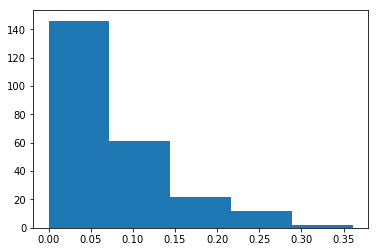

In [50]:
plt.hist(q1q2q3.id_11459_sim_score_50, 5)

(array([ 231.,    8.,    1.,    1.,    2.]),
 array([ 0.        ,  0.15310492,  0.30620983,  0.45931475,  0.61241966,
         0.76552458]),
 <a list of 5 Patch objects>)

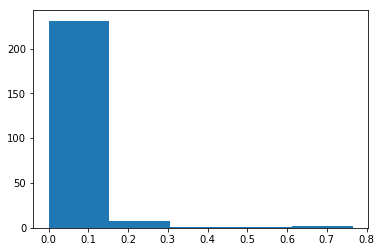

In [51]:
plt.hist(q1q2q3.id_11459_sim_score_75, 5)

(array([ 127.,   35.,   39.,   28.,   14.]),
 array([ 0.        ,  0.17747178,  0.35494355,  0.53241533,  0.7098871 ,
         0.88735888]),
 <a list of 5 Patch objects>)

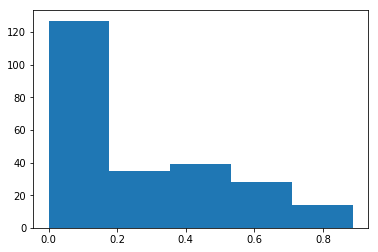

In [52]:
plt.hist(q1q2q3.id_11459_sim_score, 5)

In [53]:
data = np.array(q1q2q3.id_11459_sim_score)

In [70]:
q1q2q3.head()

,Type,count,assignment_id,student_id,grade,submitted_or_active,class_code,product_id,time_assignment_started,time_assignment_submitted,...,Unnamed: 16,id_11459_sim_score,id_11460_sim_score,id_11461_sim_score,q1_hundred,q2_hundred,q3_hundred,id_11459_sim_score_75,id_11459_sim_score_50,q1_scores
54,control,55,b4b62e65-48fb-4d33-9ac2-887b9f734b64,361612cf-6ef3-4596-b1b5-56c5feecefea,5,SUBMITTED,NLWLUT,5f57ca4a-2506-4157-acf7-6e38aa58112b_0012,2017-12-07T17:45:50+00:00,2017-12-12T18:02:41+00:00,...,NaN,0.031283,0.180466,0.338124,1,1,0,0.0,0.090468,3
64,control,65,eb7333ea-66aa-45e4-b3b5-e69fe1249024,7dc7ee09-9e24-499c-ac1b-ec86e2940234,5,SUBMITTED,Q42JXZ,5f57ca4a-2506-4157-acf7-6e38aa58112b_0020,2017-12-15T14:22:25+00:00,2017-12-15T14:39:49+00:00,...,NaN,0.356858,0.612811,0.019938,1,1,1,0.0,0.086002,3
66,control,67,eb7333ea-66aa-45e4-b3b5-e69fe1249024,44ef407b-6baf-405b-8aee-d486520e3e07,5,SUBMITTED,Q42JXZ,5f57ca4a-2506-4157-acf7-6e38aa58112b_0020,2017-12-15T14:17:26+00:00,2017-12-15T14:42:15+00:00,...,NaN,0.000000,0.000000,0.071926,1,1,1,0.0,0.134688,3
67,control,68,eb7333ea-66aa-45e4-b3b5-e69fe1249024,1a0b52e9-1a3c-4004-8e24-b718fb5cde29,5,SUBMITTED,Q42JXZ,5f57ca4a-2506-4157-acf7-6e38aa58112b_0020,2017-12-15T14:22:26+00:00,2017-12-15T14:45:49+00:00,...,NaN,0.308563,0.000000,0.080586,1,1,1,0.0,0.217795,3
68,control,69,eb7333ea-66aa-45e4-b3b5-e69fe1249024,7b92a7a6-f4d0-41b0-a602-0390393949f5,5,SUBMITTED,Q42JXZ,5f57ca4a-2506-4157-acf7-6e38aa58112b_0020,2017-12-15T14:18:17+00:00,2017-12-15T14:36:16+00:00,...,NaN,0.018584,0.000000,0.069238,1,1,1,0.0,0.000000,3


In [54]:
data[0]

0.031282674510189901

In [55]:
y, binEdges = np.histogram(q1q2q3.id_11459_sim_score, bins=5)

In [56]:
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

In [57]:
np.histogram?

In [58]:
std = np.std(y)

In [59]:
bincenters

array([ 0.08873589,  0.26620766,  0.44367944,  0.62115122,  0.79862299])

<Container object of 5 artists>

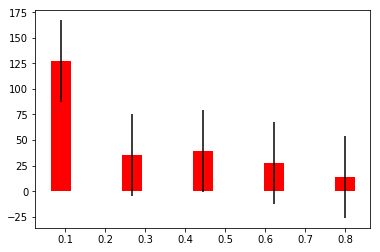

In [60]:
width      = 0.05
plt.bar(bincenters, y, width=width, color='r', yerr=std)

In [61]:
bins = np.array([0., .2, .4, .6, .8, 1.])

In [62]:
ind = np.digitize(data, bins)

In [63]:
np.digitize?

In [67]:
avg = []
for i in np.unique(ind):
    vals = []
    for j in range(data.size):
        if ind[j] == i:
            vals.append(data[j])
    avg.append(np.mean(vals))

In [64]:
err = []
for i in np.unique(ind):
    vals = []
    for j in range(data.size):
        if ind[j] == i:
            vals.append(data[j])
    err.append(np.std(vals))

In [68]:
avg

[0.04842942939573925,
 0.30037225446723365,
 0.47999623265503233,
 0.66344656304962868,
 0.85360637064950673]

In [65]:
err

[0.056768255325774217,
 0.052915505818712683,
 0.051775137558759066,
 0.059707538302351704,
 0.015163161259231601]

<Container object of 5 artists>

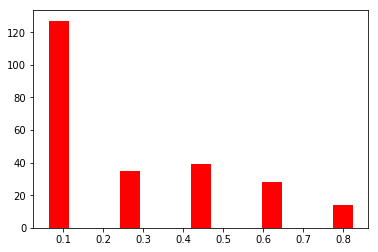

In [66]:
plt.bar(bincenters, y, width=width, color='r', yerr=err)

In [71]:
np_q1_answers

['monicas mom askes her if she like movies and monica said yes monica liked the actors and dressing up and pretending to be someone else and she also liked rock',
 'she ask aren’t you a little old to be playing make believe',
 'she said she was holdiding a mop',
 'well monica says that shes is too old for makebelieve but her mom says that your never too old for make believe ',
 'why couldnt they just go to the store and buy some blueberries',
 'she saidhey mom you like movies right',
 'that she is to old for it',
 'when monica sees her mom singing and dancing to a west side story song she said arent you a little to old to be playing make believe',
 'monica said arent you a little old for make believe',
 'who was the one danceing',
 'monica says arent you a little to old to be playing make believe',
 'your to old to be purtending mam',
 'she asks if her moms not a little too old to make believe',
 'arent you to old to play pretend ',
 'you are to old for make bleave',
 '¨ aren´t you a l

In [75]:
tokenized = []
for i in range(len(np_q1_answers)):
    j = np_q1_answers[i].split()
    tokenized.append(j)
    print(tokenized)
    
    

[['monicas', 'mom', 'askes', 'her', 'if', 'she', 'like', 'movies', 'and', 'monica', 'said', 'yes', 'monica', 'liked', 'the', 'actors', 'and', 'dressing', 'up', 'and', 'pretending', 'to', 'be', 'someone', 'else', 'and', 'she', 'also', 'liked', 'rock']]
[['monicas', 'mom', 'askes', 'her', 'if', 'she', 'like', 'movies', 'and', 'monica', 'said', 'yes', 'monica', 'liked', 'the', 'actors', 'and', 'dressing', 'up', 'and', 'pretending', 'to', 'be', 'someone', 'else', 'and', 'she', 'also', 'liked', 'rock'], ['she', 'ask', 'aren’t', 'you', 'a', 'little', 'old', 'to', 'be', 'playing', 'make', 'believe']]
[['monicas', 'mom', 'askes', 'her', 'if', 'she', 'like', 'movies', 'and', 'monica', 'said', 'yes', 'monica', 'liked', 'the', 'actors', 'and', 'dressing', 'up', 'and', 'pretending', 'to', 'be', 'someone', 'else', 'and', 'she', 'also', 'liked', 'rock'], ['she', 'ask', 'aren’t', 'you', 'a', 'little', 'old', 'to', 'be', 'playing', 'make', 'believe'], ['she', 'said', 'she', 'was', 'holdiding', 'a', 'm

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [78]:
frequency_list = []
import pprint
from collections import Counter

for i in tokenized:
    frequency_list.append(Counter(i))
    
pprint.pprint(frequency_list[:2])

[Counter({'and': 4,
          'she': 2,
          'monica': 2,
          'liked': 2,
          'monicas': 1,
          'mom': 1,
          'askes': 1,
          'her': 1,
          'if': 1,
          'like': 1,
          'movies': 1,
          'said': 1,
          'yes': 1,
          'the': 1,
          'actors': 1,
          'dressing': 1,
          'up': 1,
          'pretending': 1,
          'to': 1,
          'be': 1,
          'someone': 1,
          'else': 1,
          'also': 1,
          'rock': 1}),
 Counter({'she': 1,
          'ask': 1,
          'aren’t': 1,
          'you': 1,
          'a': 1,
          'little': 1,
          'old': 1,
          'to': 1,
          'be': 1,
          'playing': 1,
          'make': 1,
          'believe': 1})]


In [79]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

In [80]:
count_vector.fit(np_q1_answers)
count_vector.get_feature_names()

['11',
 'about',
 'absorbed',
 'according',
 'acting',
 'actors',
 'adult',
 'after',
 'agan',
 'age',
 'allowed',
 'almost',
 'also',
 'am',
 'an',
 'and',
 'anddancing',
 'angle',
 'animated',
 'annoyed',
 'anwser',
 'anwsered',
 'anymore',
 'anything',
 'are',
 'aren',
 'arent',
 'arentyou',
 'arnt',
 'around',
 'article',
 'as',
 'ask',
 'asked',
 'askes',
 'asks',
 'at',
 'balieve',
 'be',
 'because',
 'becos',
 'before',
 'begening',
 'begging',
 'beginning',
 'behind',
 'being',
 'beleave',
 'beleive',
 'beleve',
 'belieive',
 'believe',
 'believeand',
 'believepar1',
 'believewhere',
 'believing',
 'belive',
 'belivepar',
 'berryies',
 'berrys',
 'best',
 'better',
 'beubarys',
 'bielive',
 'bikws',
 'bit',
 'bleave',
 'blue',
 'blueberries',
 'blueberry',
 'blueberrys',
 'bluederes',
 'book',
 'broom',
 'buetiful',
 'but',
 'buy',
 'can',
 'cant',
 'caught',
 'childeren',
 'childhood',
 'childish',
 'clean',
 'could',
 'couldnt',
 'country',
 'craziness',
 'creeped',
 'dance',

In [81]:
len(count_vector.get_feature_names())

385